In [1]:
import numpy as np
import numpy.random as npr
import casadi as cs

import matplotlib.pyplot as plt

from given5.problem import (
    system_info,
    get_system_equations,
    get_linear_dynamics,
    build_mhe,
    default_config,
    simulate,
    ObserverLog,
    LOGGER,
)

# Session 5: MHE

In [48]:
class EKF:
    def __init__(self, x0: np.ndarray, P: float, Q: float, R: float, clip = True) -> None:
        f, h = get_system_equations(symbolic=True, noise=True)
        [dfdx, dfdw, dhdx] = get_linear_dynamics(f, h)

        nx, nw, ny = system_info(f, h)

        self.x = x0 
        self.P = P * np.eye(nx)
        self.Q = Q * np.eye(nw)
        self.R = R * np.eye(ny)


        self.dfdx = dfdx
        self.dfdw = dfdw
        self.dhdx = dhdx
        self.f = f 
        self.h = h

        self.clip = clip
        

    def __call__(self, y: np.ndarray, log: LOGGER = None):
        # Measurement Update 
        Pk = self.P
        Ck = cs.DM.full(self.dhdx(self.x))
        Lk = np.linalg.solve((Ck@Pk@Ck.T + self.R).T, Ck@Pk.T).T
        Pk -= Lk@Ck@Pk
        self.x += Lk@(y - cs.DM.full(self.h(self.x)))

        if self.clip:
            self.x = np.maximum(0.0, self.x)

        # log the state estimate and the measurement for plotting
        if log is not None:
            log("y", y)
            log("x", self.x.squeeze())

        # time update
        Ak = cs.DM.full(self.dfdx(self.x, 0)) 
        self.x = cs.DM.full(self.f(self.x, 0))
        self.P = Ak@self.P@Ak.T + self.Q 


class MHE:
    def __init__(self, Qv: float, Rv: float, Pv: float, x0: np.ndarray, N: int, clip=False, prior=False) -> None:
        self.N = N 
        self.f, self.h = get_system_equations(symbolic=True, noise=True)
        self.nx, self.nw, self.ny = system_info(self.f, self.h)
        Q = Qv * np.eye(self.nw)
        R = Rv * np.eye(self.ny)
        P = Pv * np.eye(self.nx)
        self.loss = lambda w, v: w.T @ np.linalg.inv(Q) @ w + v.T @ np.linalg.inv(R) @ v
        self.limits = [0.0, 10.0]
        
        self.y = []
        self.P = []
        self.x = [x0]

        self.prior = prior
        self.solver = build_mhe(self.loss, self.f, self.h, self.N, lbx=self.limits[0], ubx=self.limits[1], use_prior=self.prior)
        self.ekf = EKF(x0, P=P, Q=Q, R=R, clip=clip)

    def __call__(self, y: np.ndarray, log: LOGGER):
        self.y.append(y)
        self.P.append(self.ekf.P)
        # Take P before running EKF update so its Pk_ not Pk
        self.ekf(y)

        if len(self.y) > self.N:
            self.y.pop(0)
            self.P.pop(0)
            self.x.pop(0)

        if len(self.y) < self.N:
            solver = build_mhe(self.loss, self.f, self.h, len(self.y), lbx=self.limits[0], ubx=self.limits[1], use_prior=self.prior)
        else: 
            solver = self.solver 

        if self.prior:
            x, _ = solver(x0=self.x[0], P = self.P[0], y = self.y)
        else:
            x, _ = solver(self.y)
        
        self.x.append(x[-1,:])

        # log the state estimate and the measurement for plotting
        log("y", y)
        log("x", x[-1,:])


def plot_result(t: np.ndarray, x: np.ndarray, x_: np.ndarray):
    ax = plt.gca()
    c = ["C0", "C1", "C2"]
    h = []
    for i, c in enumerate(c):
        h += ax.plot(t, x_[..., i], "--", color=c)
        h += ax.plot(t, x[..., i], "-", color=c)
    ax.set_xlim(t[0], t[-1])
    if np.max(x_) >= 10.0:
        ax.set_yscale('log')
    else:
        ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("Time")
    ax.set_ylabel("Concentration")
    ax.legend(
        h,
        [
            "$A_{\mathrm{est}}$",
            "$A$",
            "$B_{\mathrm{est}}$",
            "B",
            "$C_{\mathrm{est}}$",
            "C",
        ],
        loc="lower left",
        mode="expand",
        ncol=6,
        bbox_to_anchor=(0, .9, 1, 0.2),
        borderaxespad=0,
    )
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)


## Assignment 5.1

d:\Studies\MSEE\KULeuven\Semester 3\Model Predictive Control\MPC-Project\.venv\lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Executing Homework
--------------------------------------------------------------------------------


d:\Studies\MSEE\KULeuven\Semester 3\Model Predictive Control\MPC-Project\.venv\lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

d:\Studies\MSEE\KULeuven\Semester 3\Model Predictive Control\MPC-Project\.venv\lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

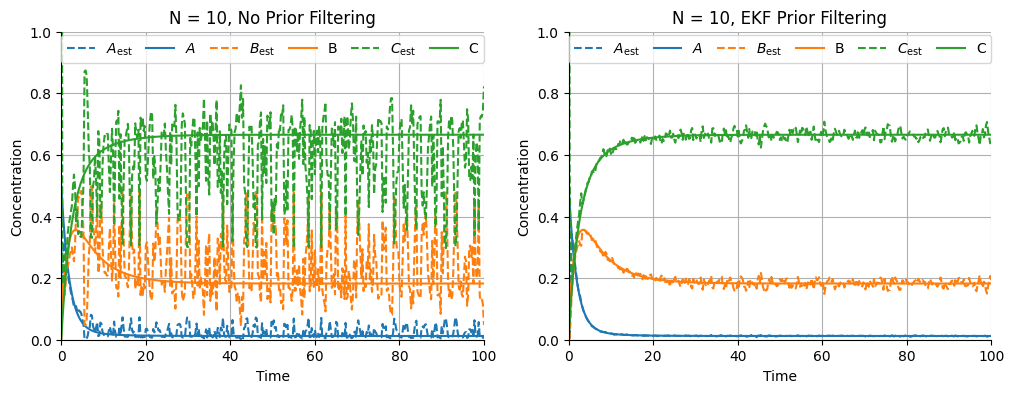

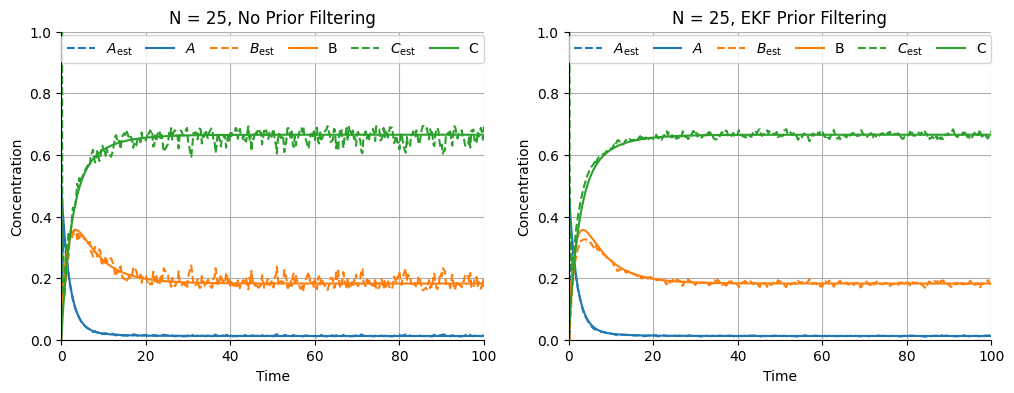

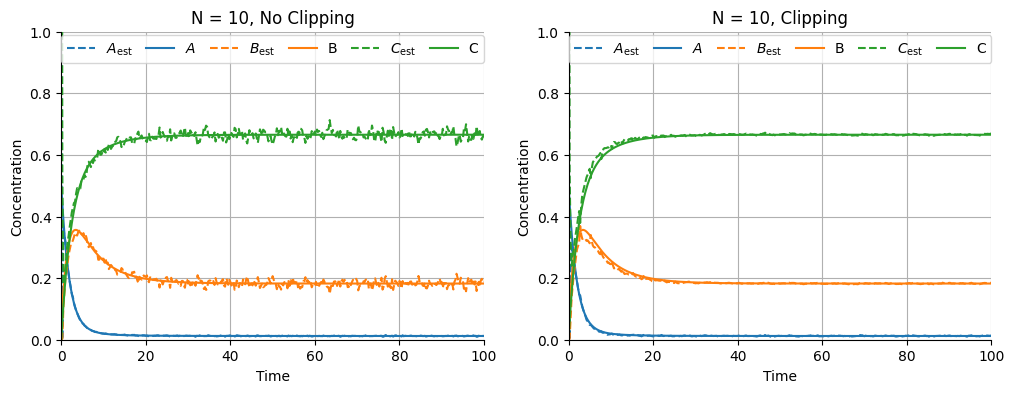

In [49]:
print("\nExecuting Homework\n" + "-" * 80)

def run_mhe(N:int, clip:bool, prior:bool):
    # problem setup
    cfg = default_config()

    Q = 0.002 ** 2 
    R = 0.25 ** 2
    P = 0.5 ** 2
    x0 = np.array([[1.],[0.],[4.]])

    mhe = MHE(Q,R,P,x0,N=N,clip=clip,prior=prior)

    # prepare log
    log = ObserverLog()
    log.append("x", cfg.x0_est)  # add initial estimate

    # simulate
    f, h = get_system_equations(noise=(0.0, cfg.sig_v), Ts=cfg.Ts, rg=cfg.rg)

    n_steps = 400
    x = simulate(cfg.x0, f, n_steps=n_steps, policy=mhe, measure=h, log=log)
    t = np.arange(0, n_steps + 1) * cfg.Ts

    return t, x, log.x

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_result(*run_mhe(10,False,False))
plt.title("N = 10, No Prior Filtering")
plt.grid(True)

plt.subplot(1,2,2)
plot_result(*run_mhe(10,False,True))
plt.title("N = 10, EKF Prior Filtering")
plt.grid(True)
plt.savefig("figs/5.1-1.pdf", bbox_inches="tight", pad_inches=0.1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_result(*run_mhe(25,False,False))
plt.title("N = 25, No Prior Filtering")
plt.grid(True)

plt.subplot(1,2,2)
plot_result(*run_mhe(25,False,True))
plt.title("N = 25, EKF Prior Filtering")
plt.grid(True)
plt.savefig("figs/5.1-2.pdf", bbox_inches="tight", pad_inches=0.1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_result(*run_mhe(10,False,True))
plt.title("N = 10, No Clipping")
plt.grid(True)

plt.subplot(1,2,2)
plot_result(*run_mhe(10,True,True))
plt.title("N = 10, Clipping")
plt.grid(True)
plt.savefig("figs/5.1-3.pdf", bbox_inches="tight", pad_inches=0.1)